We will now give an example of how to present data on a map.<br/>
Data can be points, lines, arrows, 2D fields... the principle is always the same:
* Create the projection.
* Plot using that projection.

The main package here is the [Basemap](http://matplotlib.org/basemap/) toolkit.

In [1]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
%matplotlib inline

In [2]:
mpl.rcParams.update({'font.size': 20, 'font.family': 'Times New Roman'})

# Setting up the map

The map use a [Mercator](http://matplotlib.org/basemap/users/merc.html) projection centered on southern Spain.<br/>
We add the coastline, fill the continents and label the meridians/parallels.<br/>
The resolution is set as *low* for the first tries. 

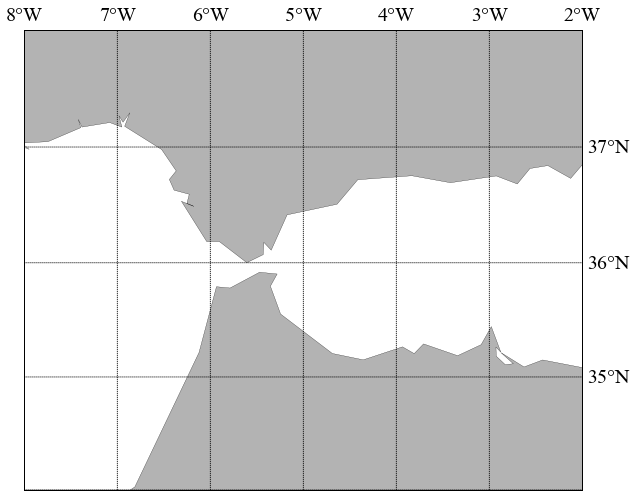

In [5]:
m = Basemap(projection='merc', llcrnrlat=34., urcrnrlat=38.,\
            llcrnrlon=-8., urcrnrlon=-2., lat_ts=35., resolution='l')
plt.figure(figsize=(10,10))
m.drawcoastlines(linewidth=.25)
m.fillcontinents(color='.7')
m.drawparallels(np.arange(30.,40.,1.), labels=[False,True,True,False])
m.drawmeridians(np.arange(-10.,2.,1.), labels=[False,True,True,False])
plt.show()

Now on this map we want to add the location of Cádiz.<br/>
We can simply look for the coordinates on the web.

**Exercise:** find a way to automatically get the coordinates by simply entering the name of the place (city).

In [9]:
loncadiz, latcadiz = -6.2826008, 36.5216471

Before adding the plot on the map, we have to compute the coordinates in the projection units, otherwise the marker won't appear.

In [10]:
loncadiz2, latcadiz2 = m(loncadiz, latcadiz)

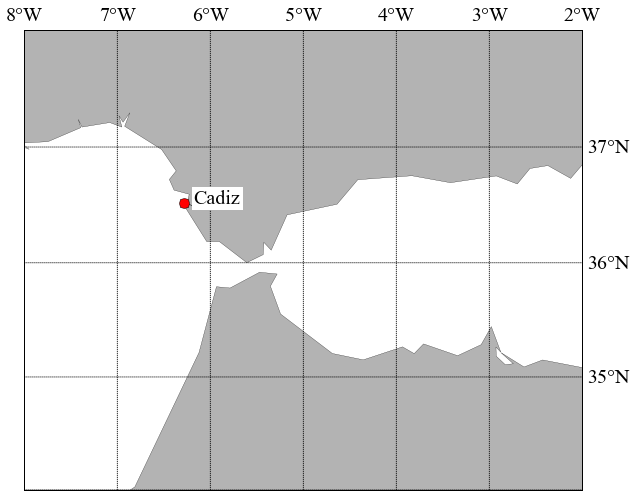

In [11]:
plt.figure(figsize=(10,10))
m.drawcoastlines(linewidth=.25)
m.fillcontinents(color='.7')
m.drawparallels(np.arange(30.,40.,1.), labels=[False,True,True,False])
m.drawmeridians(np.arange(-10.,2.,1.), labels=[False,True,True,False])
m.plot(loncadiz2, latcadiz2, 'ro', ms=10)
plt.text(loncadiz2+10000, latcadiz2, 'Cadiz', horizontalalignment='left', backgroundcolor='white')
plt.show()

# Adding a 2D field to the map.

Let's add a satellite chlorophyll concentration field.<br/>
Such data can be obtained from the [Ocean Color](http://oceancolor.gsfc.nasa.gov/cgi/l3) web.

For this example we use the 4km-resolution, monthly file from VIIRS satellite corresponding to December 2015.<br/>
Here you need to:
* download a file from Ocean Color web,
* adapt the path to the file in the following line. 

In [12]:
chlorofile = "/data_local/DataOceano/V20153352015365.L3m_MO_NPP_CHL_chlor_a_4km.nc"

## Data reading 

In [47]:
with netCDF4.Dataset(chlorofile) as nc:
    lonchloro = nc.variables['lon'][:]
    latchloro = nc.variables['lat'][:]
    chloro = nc.variables['chlor_a'][:]

We change the coordinates into the projection units. Since the coordinates are 2 vectors of different size, we need to create a grid of lon/lat before the projection. We use the [meshgrid](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.meshgrid.html) function, which returns coordinate matrices from coordinate vectors.

The operation may take a few seconds because of the size of the vectors.

In [48]:
lonchlorogrid, latchlorogrid = np.meshgrid(lonchloro, latchloro)
lonchloro2, latchloro2 = m(lonchlorogrid, latchlorogrid)

Let's check with a small plot if we're ok until now.

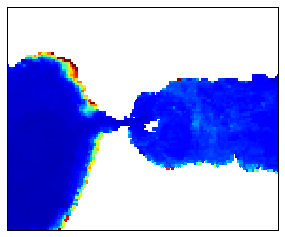

In [88]:
m.pcolormesh(lonchloro2, latchloro2, chloro, vmin=0, vmax=3.0)
plt.show()

## Data selection 

The previous plot takes a while to be produced.<br/>
**Solution:** we only keep the data in a box around our domain of interest.

In [50]:
mask_lat = (latchloro>=32.) & (latchloro<=40.)
mask_lon = (lonchloro>=-10.) & (lonchloro<=0.)
print mask_lon

[False False False ..., False False False]


In [62]:
lonchloro_domain = lonchloro[mask_lon]
latchloro_domain = latchloro[mask_lat]

For the 2D array chloro, this cannot be in one step with:

In [33]:
chloro_domain = chloro[mask_lat, mask_lon]

/usr/local/lib/python2.7/dist-packages/numpy/ma/core.py:3111: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 192 but corresponding boolean dimension is 4320
  dout = self.data[indx]


IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (192,) (240,) 

Two solutions: 1. two step indexing:

In [52]:
chloro_domain1 = chloro[mask_lat, :]
chloro_domain1 = chloro_domain1[:, mask_lon]

or 2. using the [ix_](http://docs.scipy.org/doc/numpy/reference/generated/numpy.ix_.html#numpy.ix_) functions.

In [53]:
chloro_domain2 = chloro[np.ix_(mask_lat, mask_lon)]

Let's check the size of these new arrays.

In [63]:
print lonchloro_domain.shape, latchloro_domain.shape
print chloro_domain1.shape, chloro_domain2.shape

(240,) (192,)
(192, 240) (192, 240)


We also need to be sure the 2 arrays are the same ([array_equal](https://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.array_equal.html) function), whatever the chosen method!

In [55]:
np.array_equal(chloro_domain1, chloro_domain2)

True

# Final plot

Let's combine all the elements of the previous sections to create a nice plot.

First create the same projection, but with a better resolution for the coastline and land mask.

In [74]:
m = Basemap(projection='merc', llcrnrlat=34., urcrnrlat=38.,\
            llcrnrlon=-8., urcrnrlon=-2., lat_ts=35., resolution='h')

Compute the coordinates in this new projection system.

In [75]:
lonchlorogrid, latchlorogrid = np.meshgrid(lonchloro_domain, latchloro_domain)
lonchloro_domain2, latchloro_domain2 = m(lonchlorogrid, latchlorogrid)

Create a colormap suitable for chlorophyll concentration.

In [76]:
cmap = plt.cm.BuGn

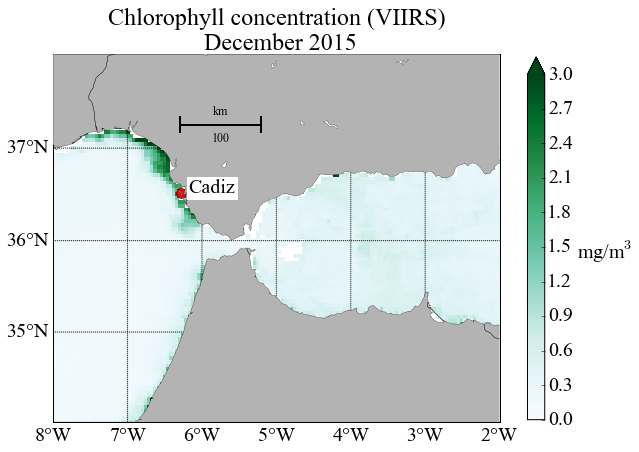

In [102]:
plt.figure(figsize=(10,10))
m.drawcoastlines(linewidth=.25, zorder=4)
m.fillcontinents(color='.7', zorder=3)
m.drawparallels(np.arange(30.,40.,1.), labels=[True,False,True,False], zorder=2)
m.drawmeridians(np.arange(-10.,2.,1.), labels=[False,True,False,True], zorder=2)
m.plot(loncadiz2, latcadiz2, 'ro', ms=10)
m.pcolormesh(lonchloro_domain2, latchloro_domain2, chloro_domain2, vmin=0, vmax=3, cmap=cmap)
m.drawcountries(zorder=4)
m.drawmapscale(-5.75, 37.25, -6., 37.25, 100., barstyle='simple', units='km', fontsize=12, zorder=6)
cbar = plt.colorbar(extend='max', shrink=0.65)
cbar.set_label('mg/m$^3$', rotation=0, horizontalalignment='left')
plt.text(loncadiz2+10000, latcadiz2, 'Cadiz', horizontalalignment='left', backgroundcolor='white', zorder=6)
plt.title('Chlorophyll concentration (VIIRS)\n December 2015', fontsize=24)
plt.savefig('./chloro201512_map.png', dpi=300)
plt.show()

Note the use of the [*zorder*](http://matplotlib.org/examples/pylab_examples/zorder_demo.html) argument in some of the plotting functions. It allows one to decide which layer comes over the other in the map, for example, the text (zorder=6) comes over the continent filling (zorder=3).

**Final remark:** 
* All the plots seen in other notebooks (pseudo-color, arrows, scatter, lines, ...) can be done on the map using Basemap. It only requires the setting of the map and the change of coordinates. 
* It can take a few tries to get the final figure, to have all the elements at the correct location. This is why it is better to first make tries with a low resolution map.
* Once we are happy with the map, we just save it.